In [1]:
import os   # handling the files
import pickle # storing numpy features
import numpy as np
from tqdm.notebook import tqdm # how much data is process till now

from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input # extract features from image data.
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add

In [2]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.1 MB/s eta 0:00:00


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"liverpool10","key":"4b7e80c7a4a88a411b512cbbaa880f81"}'}

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d adityajn105/flickr8k
!unzip flickr8k.zip

In [5]:
BASE_DIR = '/content/drive/MyDrive/flickr8k_data'
WORKING_DIR = '/content/drive/MyDrive/working'

In [6]:
model = VGG16()

# restructure model
model = Model(inputs = model.inputs , outputs = model.layers[-2].output)

# Summerize
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [7]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


In [10]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [7]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [8]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [11]:
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [12]:
len(mapping)

8091

In [13]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [14]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [15]:
clean(mapping)

In [16]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [17]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [18]:
len(all_captions)

40455

In [19]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [21]:
vocab_size

8485

In [22]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [23]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [24]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield (X1, X2), y
                X1, X2, y = list(), list(), list()
                n = 0


In [25]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256, use_cudnn=False)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')


In [ ]:
epochs = 15
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 1295s 6s/step - loss: 5.7902
227/227 ━━━━━━━━━━━━━━━━━━━━ 1285s 6s/step - loss: 4.0547
227/227 ━━━━━━━━━━━━━━━━━━━━ 1283s 6s/step - loss: 3.5949
227/227 ━━━━━━━━━━━━━━━━━━━━ 1279s 6s/step - loss: 3.3062
227/227 ━━━━━━━━━━━━━━━━━━━━ 1283s 6s/step - loss: 3.0929
227/227 ━━━━━━━━━━━━━━━━━━━━ 1319s 6s/step - loss: 2.9389
227/227 ━━━━━━━━━━━━━━━━━━━━ 1275s 6s/step - loss: 2.8251
227/227 ━━━━━━━━━━━━━━━━━━━━ 1271s 6s/step - loss: 2.7353
227/227 ━━━━━━━━━━━━━━━━━━━━ 1283s 6s/step - loss: 2.6635
227/227 ━━━━━━━━━━━━━━━━━━━━ 1296s 6s/step - loss: 2.5934
227/227 ━━━━━━━━━━━━━━━━━━━━ 1282s 6s/step - loss: 2.5261
227/227 ━━━━━━━━━━━━━━━━━━━━ 1279s 6s/step - loss: 2.4681
227/227 ━━━━━━━━━━━━━━━━━━━━ 1279s 6s/step - loss: 2.4171
227/227 ━━━━━━━━━━━━━━━━━━━━ 1288s 6s/step - loss: 2.3706
227/227 ━━━━━━━━━━━━━━━━━━━━ 1298s 6s/step - loss: 2.3257


In [ ]:
model.save(WORKING_DIR+'/best_model.keras')

In [26]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/working/best_model.keras')


In [27]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [38]:
def predict_caption(model, image, tokenizer, max_length):
    # تأكد من أن شكل المميزات هو (1, 4096)
    image_input = image.reshape(1, 4096)  # إضافة بعد جديد لتصبح (1, 4096)
    assert image_input.shape == (1, 4096), f"Expected (1, 4096) but got {image_input.shape}"

    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([image_input, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break

    final_caption = in_text.replace('startseq', '').replace('endseq', '').strip()
    return final_caption

In [29]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm
import json

actual, predicted = list(), list()
results = {}

for key in tqdm(test):
    # الكابشن الحقيقي
    captions = mapping[key]
    actual_captions = [caption.split() for caption in captions]
    feature_vector = features[key].squeeze()  # حول (1, 4096) إلى (4096,)
    assert feature_vector.shape == (4096,), f"Expected (4096,) but got {feature_vector.shape}"
    y_pred = predict_caption(model, feature_vector, tokenizer, max_length)
    y_pred_tokens = y_pred.split()

    # تخزين النتائج
    actual.append(actual_captions)
    predicted.append(y_pred_tokens)

    results[key] = {
        "reference": captions,
        "generated": y_pred
    }

# حساب BLEU
bleu_1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
bleu_2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))

results["overall_scores"] = {
    "BLEU-1": bleu_1,
    "BLEU-2": bleu_2
}

# حفظ النتائج في JSON
with open('/content/drive/MyDrive/working/bleu_scores.json', 'w') as f:
    json.dump(results, f, indent=4, ensure_ascii=False)

# طباعة النتائج
print("BLEU-1: %f" % bleu_1)
print("BLEU-2: %f" % bleu_2)


100%|██████████| 810/810 [15:43<00:00,  1.17s/it]


BLEU-1: 0.403705
BLEU-2: 0.229855


In [51]:
!pip install gradio

# الآن يمكنك استيراد Gradio واستخدامه
import gradio as gr
# Add these imports at the top
from transformers import pipeline
import gradio as gr

# Initialize translation pipeline (this will download the model)
translator = pipeline("translation_en_to_ar", model="Helsinki-NLP/opus-mt-en-ar")

def translate_caption(caption):
    # Remove startseq and endseq
    clean_caption = caption.replace('startseq', '').replace('endseq', '').strip()
    # Translate
    translation = translator(clean_caption)[0]['translation_text']
    return translation

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cpu


In [47]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
two dogs play in the grass


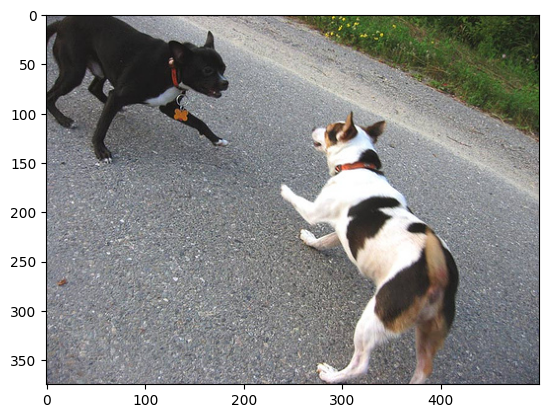

In [52]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
two men in skis are walking down snowy street


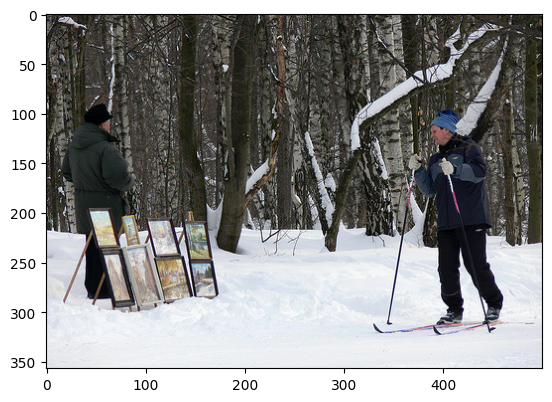

In [49]:
 generate_caption("101669240_b2d3e7f17b.jpg")

---------------------Actual---------------------
startseq man in pink shirt climbs rock face endseq
startseq man is rock climbing high in the air endseq
startseq person in red shirt climbing up rock face covered in assist handles endseq
startseq rock climber in red shirt endseq
startseq rock climber practices on rock climbing wall endseq
--------------------Predicted--------------------
man is climbing rock wall


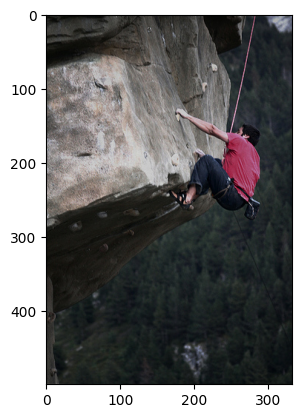

In [50]:
generate_caption("997722733_0cb5439472.jpg")

In [43]:
from transformers import pipeline
import gradio as gr

# Initialize translation pipeline (this will download the model)
translator = pipeline("translation_en_to_ar", model="Helsinki-NLP/opus-mt-en-ar")

def translate_caption(caption):
    # Remove startseq and endseq
    clean_caption = caption.replace('startseq', '').replace('endseq', '').strip()
    # Translate
    translation = translator(clean_caption)[0]['translation_text']
    return translation

Device set to use cpu


In [44]:
from PIL import Image
from transformers import pipeline
import gradio as gr

# Initialize translation
try:
    translator = pipeline("translation_en_to_ar", model="Helsinki-NLP/opus-mt-en-ar")
except Exception as e:
    print(f"Failed to load translator: {e}")
    translator = None

def process_image(image):
    try:
        # Save temporary image
        temp_path = os.path.join(WORKING_DIR, "temp.jpg")
        image.save(temp_path)

        # Load and preprocess image
        img = load_img(temp_path, target_size=(224, 224))
        img = img_to_array(img)
        img = img.reshape((1, 224, 224, 3))
        img = preprocess_input(img)

        # Extract features using ResNet50
        resnet_model = VGG16(weights='imagenet')
        resnet_model = Model(inputs=resnet_model.inputs, outputs=resnet_model.layers[-2].output)
        image_features = resnet_model.predict(img, verbose=0)

        # Generate caption
        y_pred = predict_caption(model, image_features, tokenizer, max_length)
        clean_caption = y_pred.replace('startseq', '').replace('endseq', '').strip()

        # Translate caption
        if translator:
            translated = translate_caption(y_pred)
        else:
            translated = "Translation service not available"

        return clean_caption, translated

    except Exception as e:
        return f"Error: {str(e)}", "Error"
    finally:
        # Clean up temp file
        if os.path.exists(temp_path):
            os.remove(temp_path)

# Verify everything is loaded properly
print("=== System Check ===")
print(f"Model loaded: {'yes' if model else 'no'}")
print(f"Tokenizer loaded: {'yes' if tokenizer else 'no'}")
print(f"Translator loaded: {'yes' if translator else 'no'}")
print(f"Features loaded: {'yes' if features else 'no'}")

# Launch interface
iface = gr.Interface(
    fn=process_image,
    inputs=gr.Image(type="pil", label="Upload Image"),
    outputs=[
        gr.Textbox(label="Generated Caption"),
        gr.Textbox(label="Arabic Translation")
    ],
    title="Image Captioning with Translation",
    description="Upload an image to generate an English caption and its Arabic translation.",
    allow_flagging="never"
)

iface.launch(debug=True)

Device set to use cpu


=== System Check ===
Model loaded: yes
Tokenizer loaded: yes
Translator loaded: yes
Features loaded: yes


/usr/local/lib/python3.11/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e70d99c954229de731.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_23']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_46']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_69']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://e70d99c954229de731.gradio.live
